In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from DGPs import make_DGP_MF, \
                 make_DGP_jointly_Gaussian, \
                 make_DGP_inducing_locations_points, \
                 run_optimisation, \
                 sample, \
                 dtype

np.random.seed(1)

/home/ik359/Environments/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Generate data

In [2]:
D = 50
M = 10
S = 10
noise_std = 1e-2

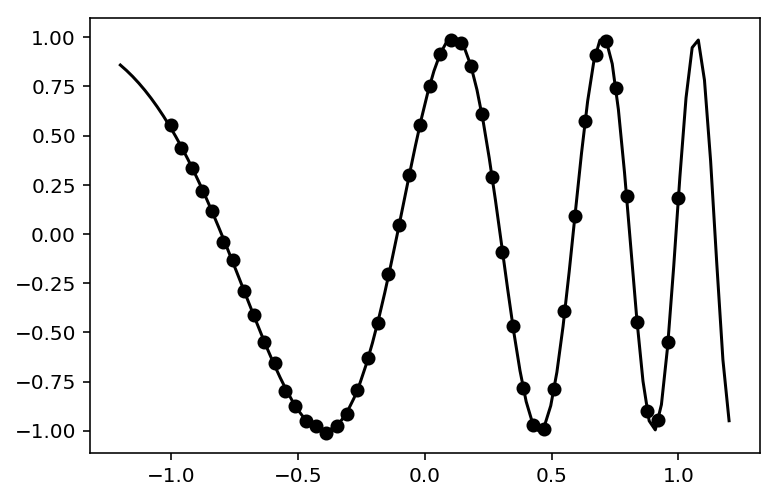

In [3]:
xs = np.linspace(-1, 1, D)
xs_test = np.linspace(-1.2, 1.2, 100)
                     
func = lambda x: np.sin(7 * np.exp(x))
ys = func(xs) + noise_std * np.random.randn(D) 

plt.plot(xs_test, func(xs_test), 'k')
plt.plot(xs, ys, 'ko')

In [4]:
def plot_DGP(xs_test, samples, fontsize=16, figsize=(20, 5)):
    titles = \
    [r'$f_1(\mathbf{X})$',
     r'$f_2(\mathbf{X})$',
     r'$(f_2 \circ f_1)(\mathbf{X})$']
    
    plt.figure(figsize=figsize)

    for p in range(3):
        plt.subplot(1, 3, p + 1)
        for s in samples[p]:
            plt.plot(xs_test, s, color='k', alpha=0.05)
            
        if p == 4:
            plt.plot(xs, ys, 'k.', markersize=12)
            
        plt.xticks([-1.5, -1, 0, 1, 1.5], ['', '-1', '0', '1', ''], fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        
        sns.despine(trim=True)
        plt.title(titles[p], fontsize=fontsize + 5)

# Mean-field

In [5]:
layers_MF, t_neg_lower_bound, t_X, t_Y = make_DGP_MF(n_layers=2, S=S, M=M, noise_std=noise_std, last_periodic=True)
feed_dict = {t_X: xs.reshape(-1, 1), t_Y: ys.reshape(-1, 1)}
t_lr = tf.placeholder(shape=(), dtype=dtype)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)
# gradients, variables = zip(*optimiser.compute_gradients(t_neg_lower_bound))
# gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
# optimiser = optimiser.apply_gradients(zip(gradients, variables))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = run_optimisation(t_neg_lower_bound, sess, optimiser, t_lr, feed_dict, n_steps=10000, lr_init=1e-3, lr_reduce=2, print_loss=1000)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0: 111630.72
1000: 350.79
2000: 255.38
3000: 262.94
4000: 331.32
5000: 265.94
6000: 149.68
7000: 159.79
8000: 154.26
9000: 148.57
10000: 52.57
0: 98.09
1000: 48.95
2000: 54.29
3000: 66.37
4000: 31.02
5000: 39.33
6000: 26.00
7000: 26.16
8000: 22.79
9000: 9.07
10000: -0.49
0: -6.14
1000: 2.21
2000: 1.90
3000: -5.60
4000: -7.91
5000: -3.64
6000: 11.05
7000: 6.88
8000: 8.03
9000: -15.00
10000: -22.32


In [6]:
feed_dict = {t_X: xs_test.reshape(-1, 1)}
samples_MF = sample(layers_MF, sess, feed_dict, S)

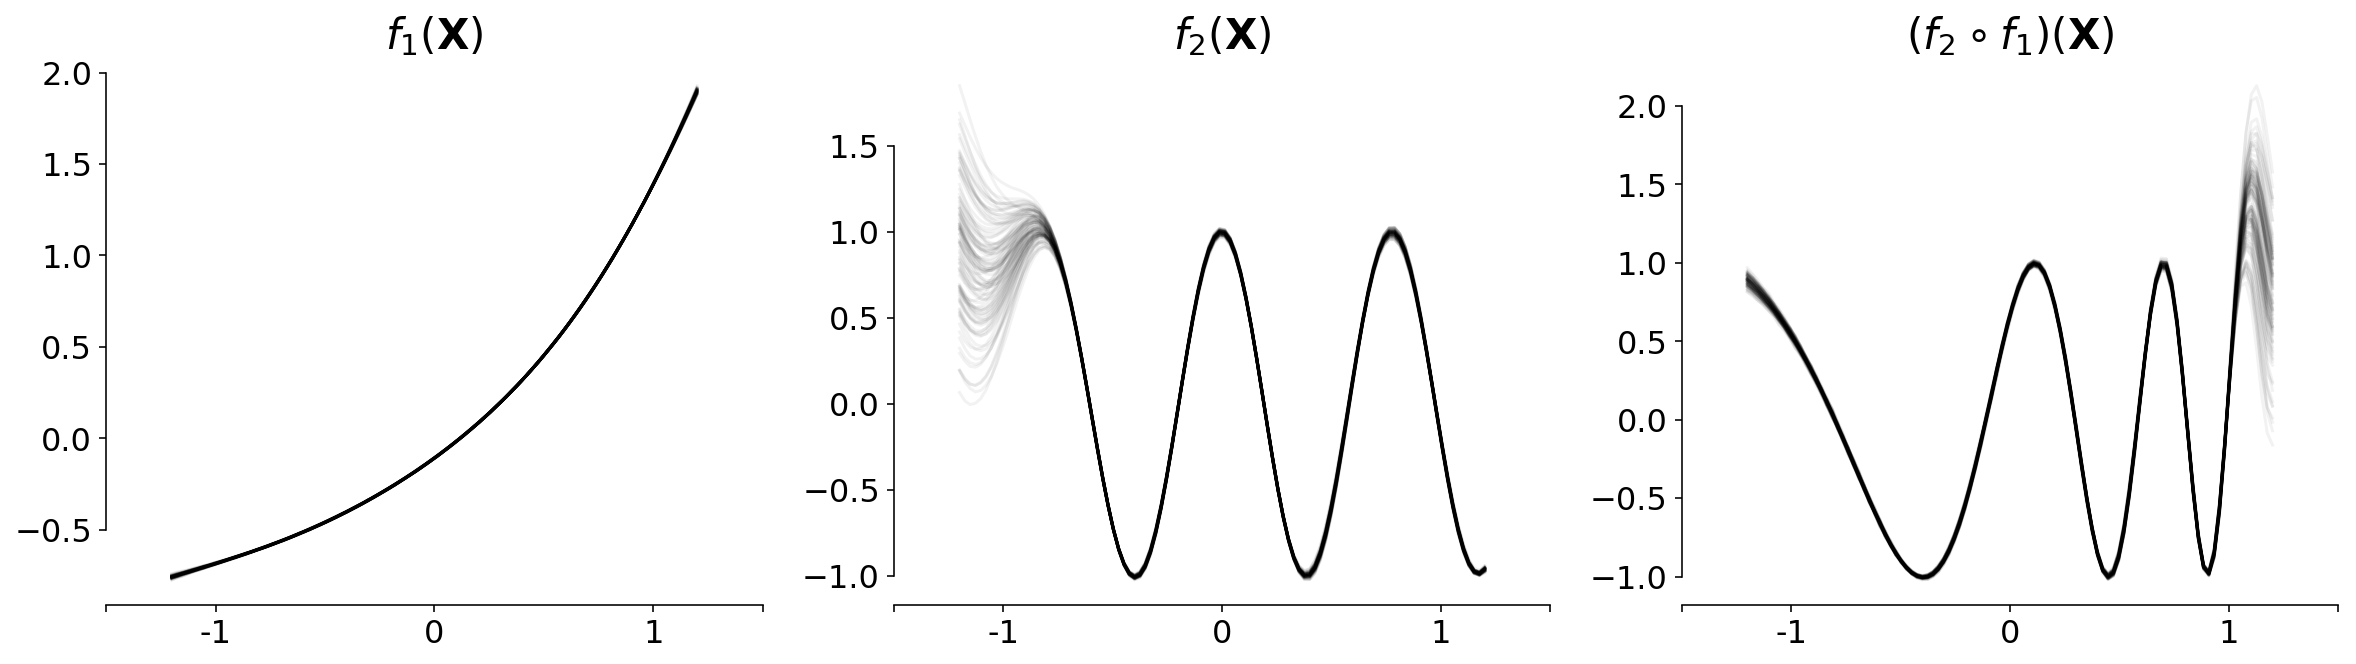

In [7]:
plot_DGP(xs_test, samples_MF)

# Jointly Gaussian

In [8]:
layers_jointly_Gaussian, t_neg_lower_bound, t_X, t_Y = \
    make_DGP_jointly_Gaussian(n_layers=2, S=S, M=M, noise_std=noise_std, last_periodic=True)
feed_dict = {t_X: xs.reshape(-1, 1), t_Y: ys.reshape(-1, 1)}
t_lr = tf.placeholder(shape=(), dtype=dtype)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)
# gradients, variables = zip(*optimiser.compute_gradients(t_neg_lower_bound))
# gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
# optimiser = optimiser.apply_gradients(zip(gradients, variables))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = run_optimisation(t_neg_lower_bound, sess, optimiser, t_lr, feed_dict, n_steps=10000, lr_init=1e-3, lr_reduce=2, print_loss=1000)

0: 112318.90
1000: 778.55
2000: 461.53
3000: 467.06
4000: 259.76
5000: 293.49
6000: 219.03
7000: 340.60
8000: 288.20
9000: 170.69
10000: 168.89
0: 250.77
1000: 132.75
2000: 164.78
3000: 177.92
4000: 136.78
5000: 43.98
6000: 95.34
7000: 38.65
8000: 106.12
9000: 85.87
10000: 67.74
0: 32.25
1000: 25.96
2000: 34.88
3000: 22.13
4000: 33.92
5000: 20.24
6000: 22.23
7000: -11.98
8000: -5.13
9000: 20.01
10000: -23.52


In [9]:
feed_dict = {t_X: xs_test.reshape(-1, 1)}
samples_jointly_Gaussian = sample(layers_jointly_Gaussian, sess, feed_dict, S)

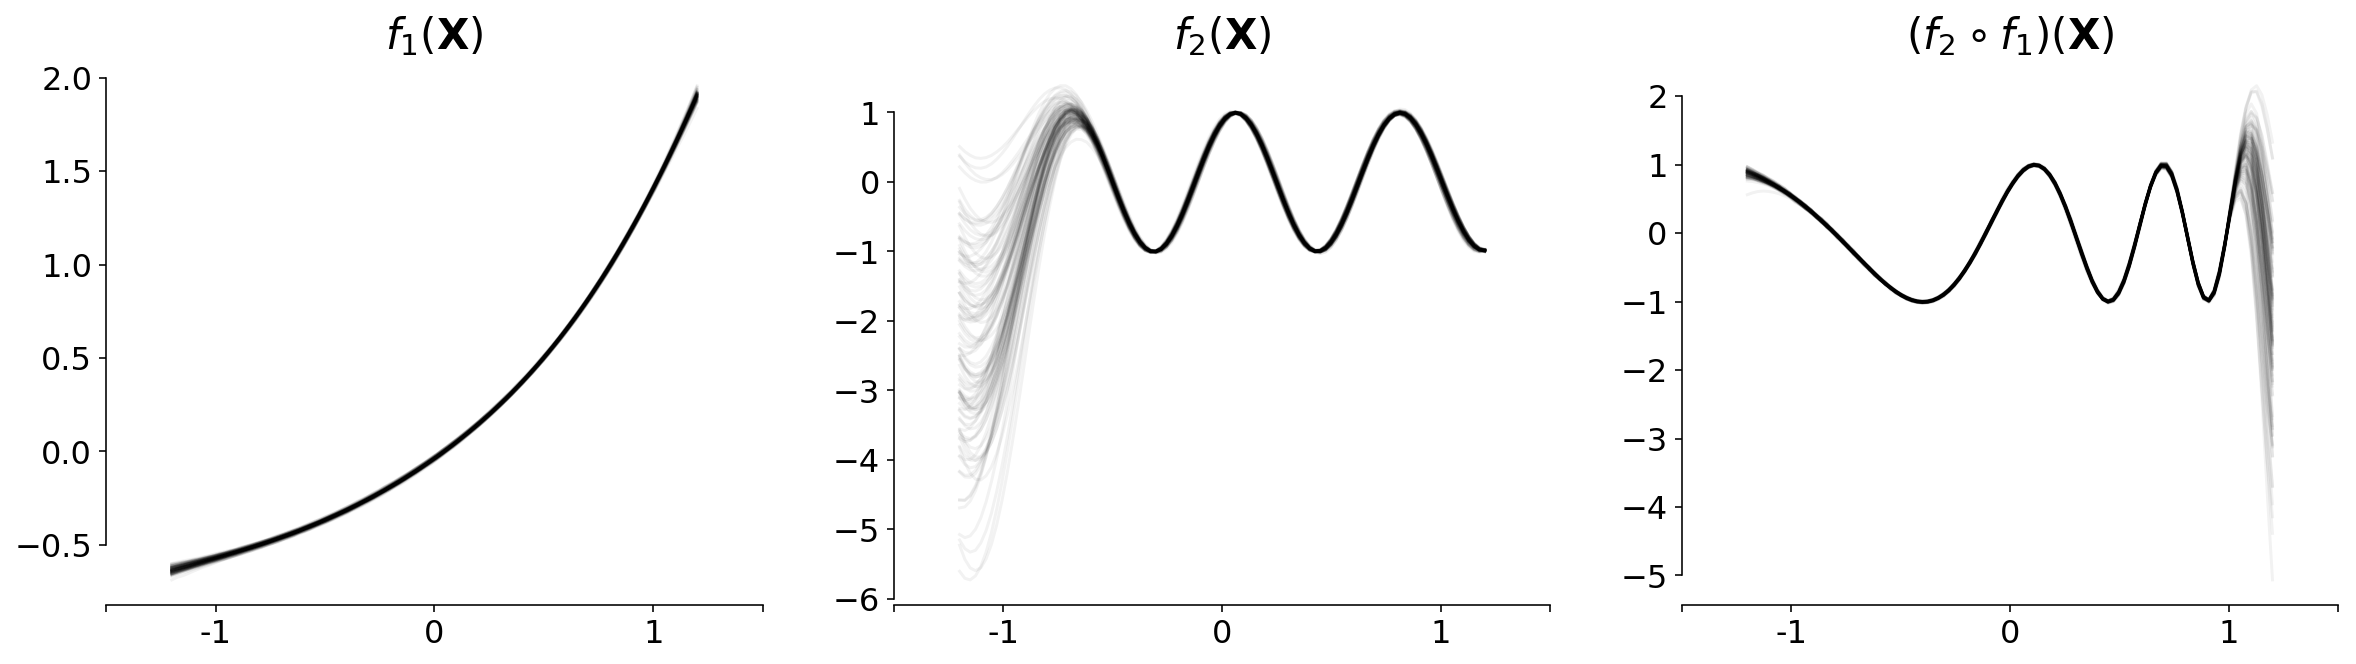

In [10]:
plot_DGP(xs_test, samples_jointly_Gaussian)

# Inducing inputs as inducing locations

In [11]:
layers_inducing_locations_points, t_neg_lower_bound, t_X, t_Y, t_beta_jitter = \
    make_DGP_inducing_locations_points(n_layers=2, S=S, M=M, noise_std=noise_std, last_periodic=True)
feed_dict = {t_X: xs.reshape(-1, 1), t_Y: ys.reshape(-1, 1), t_beta_jitter: 1e8}
t_lr = tf.placeholder(shape=(), dtype=dtype)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)
# gradients, variables = zip(*optimiser.compute_gradients(t_neg_lower_bound))
# gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
# optimiser = optimiser.apply_gradients(zip(gradients, variables))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = run_optimisation(t_neg_lower_bound, sess, optimiser, t_lr, feed_dict, n_steps=10000, lr_init=1e-3, lr_reduce=2, print_loss=1000)

0: 112503.30
1000: 518.53
2000: 265.20
3000: 239.72
4000: 296.20
5000: 195.84
6000: 191.96
7000: 198.66
8000: 471.16
9000: 121.56
10000: 99.92
0: 130.06
1000: 32.22
2000: 60.73
3000: 80.00
4000: 57.09
5000: 126.34
6000: 16.08
7000: 15.98
8000: 47.26
9000: 11.98
10000: -3.86
0: 19.53
1000: -0.05
2000: -9.97
3000: 1.11
4000: -29.96
5000: -23.22
6000: -13.60
7000: -11.15
8000: -34.67
9000: -36.48
10000: 36.18


In [12]:
feed_dict = {t_X: xs_test.reshape(-1, 1)}
samples_inducing_locations_points = sample(layers_inducing_locations_points, sess, feed_dict, S)

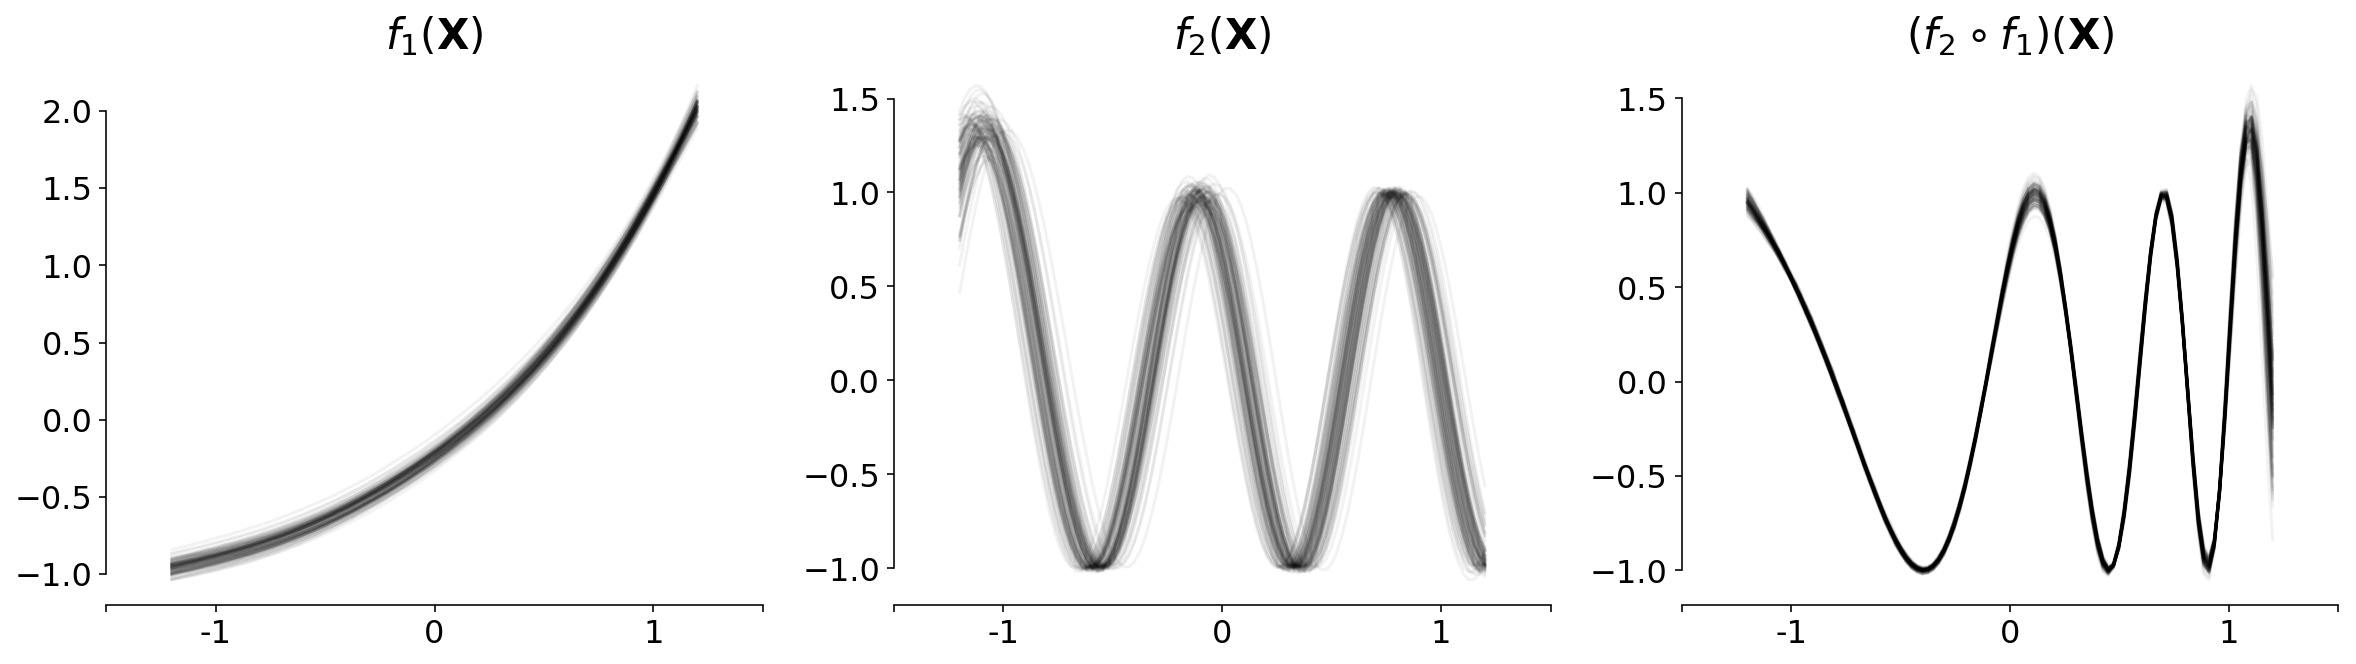

In [13]:
plot_DGP(xs_test, samples_inducing_locations_points)